In [1]:
import pandas as pd
import numpy as np

from scipy.stats import pearsonr
from scipy.special import inv_boxcox
from scipy.stats import boxcox
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller

import statsmodels.api as sm

import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline 

import warnings
warnings.simplefilter('ignore')

In [2]:
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 100)

#### read csv files from kaggle 

In [3]:
df_gemini_price_d = pd.read_csv('datasets/kaggle/BTCUSD_day.csv')
df_gemini_price_1h = pd.read_csv('datasets/kaggle/BTCUSD_1hr.csv')

#### convert columns to datetime

In [4]:
df_gemini_price_d['Date'] = pd.to_datetime(df_gemini_price_d['Date'])
df_gemini_price_1h['Date'] = pd.to_datetime(df_gemini_price_1h['Date'])

#### verify the range of datetime in dataframes

In [5]:
print('------------', 'df_gemini_price_d', '------------')
print(df_gemini_price_d['Date'].max())
print(df_gemini_price_d['Date'].min())
print('------------', 'df_gemini_price_1h', '------------')
print(df_gemini_price_1h['Date'].max())
print(df_gemini_price_1h['Date'].min())

------------ df_gemini_price_d ------------
2020-04-09 00:00:00
2015-10-08 00:00:00
------------ df_gemini_price_1h ------------
2020-04-09 00:00:00
2015-10-08 13:00:00


#### verify the numbers of lines in dataframes

In [6]:
print('------------', 'df_coinmarket_price_d', '------------')
print(df_gemini_price_d.shape[0])
print('------------', 'df_coinmarket_price_1h', '------------')
print(df_gemini_price_1h.shape[0])

------------ df_coinmarket_price_d ------------
1646
------------ df_coinmarket_price_1h ------------
39468


In [25]:
class ARIMAForecast(object):
    
    def __init__(self, df, percentage_train_size, periodicity, box_cox):
        
        self.df = df
        self.percentage_train_size = percentage_train_size
        self.periodicity = periodicity
        self.box_cox = box_cox
        self.fitted_lambda = 0
        
    def perform(self):
        
        best_params, train_size, y_train_predict = self.grid_search_model()
                
        array_pred = np.array([])
        
        date_test = self.df[train_size:].index
        count = 0
        total = len(date_test)
        
        for current_datetime in date_test:

            pred = self.prediction(best_params = best_params, current_datetime = current_datetime)
            array_pred = np.append(array_pred, pred)
#             print('current_datetime ->', current_datetime)
#             print('pred ->', pred)
            print('---')
            count += 1
            print(round(count/total*100, 2))

        print('---')
        
        if self.box_cox:
            print('box_cox', self.box_cox)
            array_pred = inv_boxcox(array_pred, self.fitted_lambda)
            self.df['Close'] = inv_boxcox(self.df['Close'], self.fitted_lambda)
        
        date_train = self.df[:train_size].index
#         date_train = y_train_predict.index
        y_train = self.df[:train_size]['Close'].values
        
        date_test = self.df[train_size:].index
        y_test = self.df[train_size:]['Close'].values
        
        data_train = {
          'date_train': date_train,
          'y_train': y_train,
          'y_train_predict': y_train_predict.values
        }

        data_test = {
            'date_test': date_test,
            'y_test': y_test,
            'y_test_predict': array_pred
        }

        df_train = pd.DataFrame(data_train)
        df_test = pd.DataFrame(data_test)

        mae, mape, mse, rmse, rmspe, r2, pearson = self.perform_metrics(df_test['y_test'],
                                                                        df_test['y_test_predict'])
        print('mae', mae,
              'mape', mape,
              'mse', mse,
              'rmse', rmse,
              'rmspe', rmspe,
              'r2', r2,
              'pearson', pearson)

        
        return df_train, df_test
        
    def perform_metrics(self, y_truth, y_forecasted): 

        mae = round(mean_absolute_error(y_truth, y_forecasted) ,4)
        mape = round(np.mean(np.abs((y_truth - y_forecasted) / y_truth)) * 100, 4)
        mse = round(mean_squared_error(y_truth, y_forecasted), 4)
        rmse = round(mse**(0.5), 4)
        rmspe = round((np.sqrt(np.mean(np.square((y_truth - y_forecasted) / y_truth)))) * 100, 4)
        r2 = round(r2_score(y_truth, y_forecasted), 4)
        try:
            corr, _ = pearsonr(y_truth, y_forecasted)
            pearson = round(corr, 4)
        except:
            pearson = None

        return mae, mape, mse, rmse, rmspe, r2, pearson
    
    def prediction(self, best_params, current_datetime):
        
        p = best_params['p_order']
        d = best_params['d_order']
        q = best_params['q_order']

        if self.periodicity == '1_day':
            train_datetime = (current_datetime - pd.Timedelta(days = 1))

        if self.periodicity == '1_hour':
            train_datetime = (current_datetime - pd.Timedelta(hours = 1))

        model = sm.tsa.statespace.SARIMAX(self.df[:train_datetime], order = (p, d, q), initialization='approximate_diffuse')
        fit_model = model.fit(enforce_stationarity=False, enforce_invertibility=False)
        
        pred = fit_model.predict(start = current_datetime, end = current_datetime)
#         print('train_datetime ->', train_datetime)
#         print('self.df[:train_datetime] ->', self.df[:train_datetime].index[-1])
        
        return pred
        
    def grid_search_model(self):
        
        train_size = int(len(self.df) * self.percentage_train_size)
        
        if self.box_cox:
            print('box_cox', self.box_cox)
            fitted_data, fitted_lambda = boxcox(self.df['Close'])
            self.df['Close'] = fitted_data
            self.fitted_lambda = fitted_lambda
        
        best_aic = np.inf 
        best_params = None
        best_fit = None
        
        p_range = range(6)
        q_range = range(6)
        d_range = range(3) # [0,1,2]

        for d in d_range:
            
            n_diff = 0
            X = self.df[:train_size]['Close'].values
            
            while n_diff < d:
                X = np.diff(X)
                n_diff +=1
            
            result = adfuller(X[d:]) #[d:] exclude the first d nan values
            p_value = result[1]
            
            if p_value < 0.05:
                print('stationary d:', d)
                #stationary
                break

        for p in p_range:
            for q in q_range:
                try:
                    model = sm.tsa.statespace.SARIMAX(self.df[:train_size], order=(p, d, q), initialization='approximate_diffuse')

                    fit_model = model.fit(enforce_stationarity=False, enforce_invertibility=False)

                    if fit_model.aic < best_aic:

                        best_aic = fit_model.aic
                        best_params = {'p_order': p, 'd_order': d, 'q_order': q}
                        best_fit = fit_model

                except: continue

        print('AIC', best_aic, 'best_params', best_params)
        
        y_train_predict = best_fit.fittedvalues
        
        return best_params, train_size, y_train_predict

In [19]:
### MAIN

df = df_gemini_price_d.copy()
# df = df_gemini_price_1h.copy()

df = df.set_index('Date')
df = df.sort_values(by = ['Date'])
df = df.loc[:, ['Close']]

df = df.asfreq('D') # D or H

arima_forecast = ARIMAForecast(df = df,
                               percentage_train_size = 0.80,
                               periodicity = '1_day',
                               box_cox = False
                               )
df_train, df_test = arima_forecast.perform()

stationary d: 1
AIC 18637.80520639137 best_params {'p_order': 4, 'd_order': 1, 'q_order': 5}
---
0 2
---
1 2
---
1 2
---
1 2
---
2 2
---
2 2
---
2 2
---
2 2
---
3 2
---
3 2
---
3 2
---
4 2
---
4 2
---
4 2
---
5 2
---
5 2
---
5 2
---
5 2
---
6 2
---
6 2
---
6 2
---
7 2
---
7 2
---
7 2
---
8 2
---
8 2
---
8 2
---
8 2
---
9 2
---
9 2
---
9 2
---
10 2
---
10 2
---
10 2
---
11 2
---
11 2
---
11 2
---
12 2
---
12 2
---
12 2
---
12 2
---
13 2
---
13 2
---
13 2
---
14 2
---
14 2
---
14 2
---
15 2
---
15 2
---
15 2
---
15 2
---
16 2
---
16 2
---
16 2
---
17 2
---
17 2
---
17 2
---
18 2
---
18 2
---
18 2
---
18 2
---
19 2
---
19 2
---
19 2
---
20 2
---
20 2
---
20 2
---
21 2
---
21 2
---
21 2
---
22 2
---
22 2
---
22 2
---
22 2
---
23 2
---
23 2
---
23 2
---
24 2
---
24 2
---
24 2
---
25 2
---
25 2
---
25 2
---
25 2
---
26 2
---
26 2
---
26 2
---
27 2
---
27 2
---
27 2
---
28 2
---
28 2
---
28 2
---
28 2
---
29 2
---
29 2
---
29 2
---
30 2
---
30 2
---
30 2
---
31 2
---
31 2
---
31 2
---
32 2
--

In [24]:
# ARIMA 1d feito
# AIC 18637.80520639137 best_params {'p_order': 4, 'd_order': 1, 'q_order': 5}
# mae 268.9678 mape 3.1188 mse 169413.5542 rmse 411.5988 rmspe 5.4496 r2 0.9261 pearson 0.9631

In [15]:
# ARIMA 1h feito
# AIC 354434.4184461638 best_params {'p_order': 4, 'd_order': 1, 'q_order': 3}
# mae 43.9093 mape 0.5051 mse 6862.6239 rmse 82.841 rmspe 1.007 r2 0.997 pearson 0.9985

In [23]:
# df_train.tail()
df_test.head()

# df_train.to_csv('train_arima_1d.csv', sep = "\t", index = False)
df_test.to_csv('test_arima_1d.csv', sep = "\t", index = False)
# pd.read_csv('train_arima_1d.csv', sep = "\t")
pd.read_csv('test_arima_1d.csv', sep = "\t")

# df_train.to_csv('train_arima_1h.csv', sep = "\t", index = False)
# df_test.to_csv('test_arima_1h.csv', sep = "\t", index = False)
# pd.read_csv('train_arima_1h.csv', sep = "\t")
# pd.read_csv('test_arima_1h.csv', sep = "\t")

date_test   y_test  y_test_predict
0    2019-05-16  7881.38     8349.370885
1    2019-05-17  7361.92     7779.178603
2    2019-05-18  7262.52     7471.039145
3    2019-05-19  8192.44     7203.230906
4    2019-05-20  8003.97     8196.248572
..          ...      ...             ...
325  2020-04-05  6775.21     6847.823688
326  2020-04-06  7336.96     6767.456726
327  2020-04-07  7201.81     7359.254045
328  2020-04-08  7369.60     7154.488334
329  2020-04-09  7315.25     7445.470919

[330 rows x 3 columns]

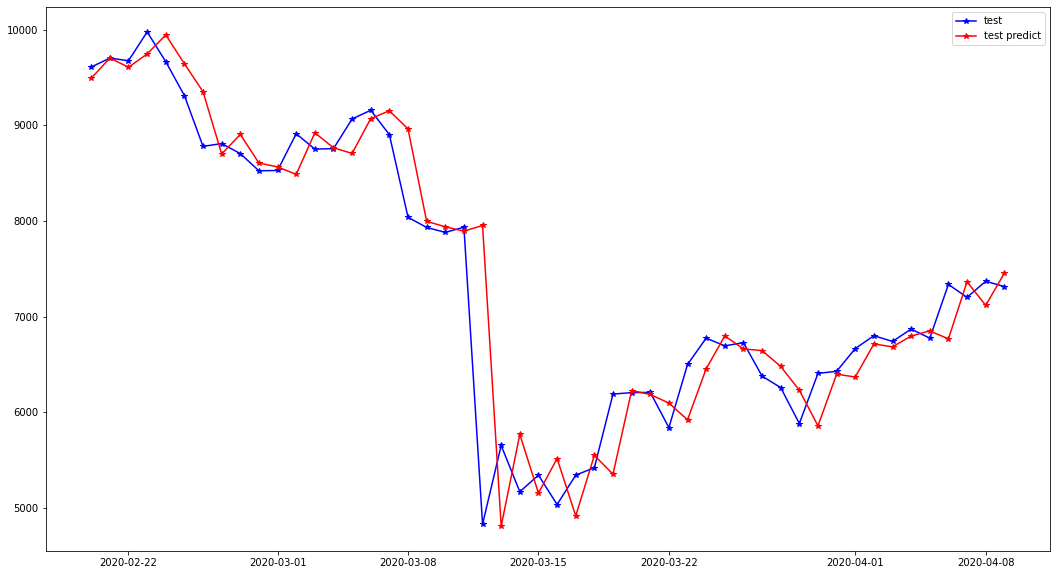

In [24]:
fig, ax = plt.subplots(figsize=(18, 10))

# ax.plot(df_train['date_train'], df_train['y_train'], label = 'train', color="blue")
# ax.plot(df_train['date_train'], df_train['y_train_predict'], '--', label = 'train predict', color="red")

ax.plot(df_test['date_test'], df_test['y_test'], '*-', label = 'test', color="blue")
ax.plot(df_test['date_test'], df_test['y_test_predict'], '*-', label = 'test predict', color="red")

ax.legend()
plt.show()

In [83]:
a = [2, 4, 16, 32, 64, 128, 256]
data = { 'a': a}
df_a = pd.DataFrame(data)
df_a['diff_1'] = df_a['a'].diff()
df_a['diff_2'] = df_a['diff_1'].diff()
df_a[:5]

a  diff_1  diff_2
0   2     NaN     NaN
1   4     2.0     NaN
2  16    12.0    10.0
3  32    16.0     4.0
4  64    32.0    16.0

In [85]:
last_close_price = df_a[:5]['a'].values[-1]
before_last_close_price = df_a[:5]['a'].values[-2]
last_close_diff_price = last_close_price - before_last_close_price
pred = last_close_price + last_close_diff_price + df_a[:6]['diff_2'].values[-1]
pred

128.0

In [20]:
df = df_gemini_price_d.copy()
df = df.set_index('Date')
df = df.sort_values(by = ['Date'])
df = df.loc[:, ['Close']]

df = df.asfreq('D') # D or H

model = sm.tsa.statespace.SARIMAX(df[:'2019-04-30'], order=(1, 2, 0))
# print(df[:'2019-04-29'].index[-1])
print(df[:'2019-04-30'].index[-1])
print(df[:'2019-04-30'].values[-1])
fit_model = model.fit(enforce_stationarity=False, enforce_invertibility=False)

pred = fit_model.predict(start = '2019-04-30', end = '2019-04-30', dynamic = False)
pred

2019-04-30 00:00:00
[5266.34]


Date
2019-04-30    5137.997029
Freq: D, dtype: float64